In [30]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [21]:
model = load_model("best_model.keras")
IMG_SIZE = 224
def preprocess(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode="rgb")
    x = image.img_to_array(img)       # (H, W, 3), dtype=float32
    x = x / 255.0                     # giống rescale=1/255.0
    x = np.expand_dims(x, axis=0)     # thêm batch dimension
    return x, img


In [22]:
def make_gradcam_heatmap(img_array, model,
                         last_conv_name="conv5_block16_concat",
                         pred_index=None):
    # lấy layer conv cuối trong backbone
    last_conv_layer = model.get_layer(last_conv_name)

    # build grad_model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


c:\Users\Phi Yen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_2']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


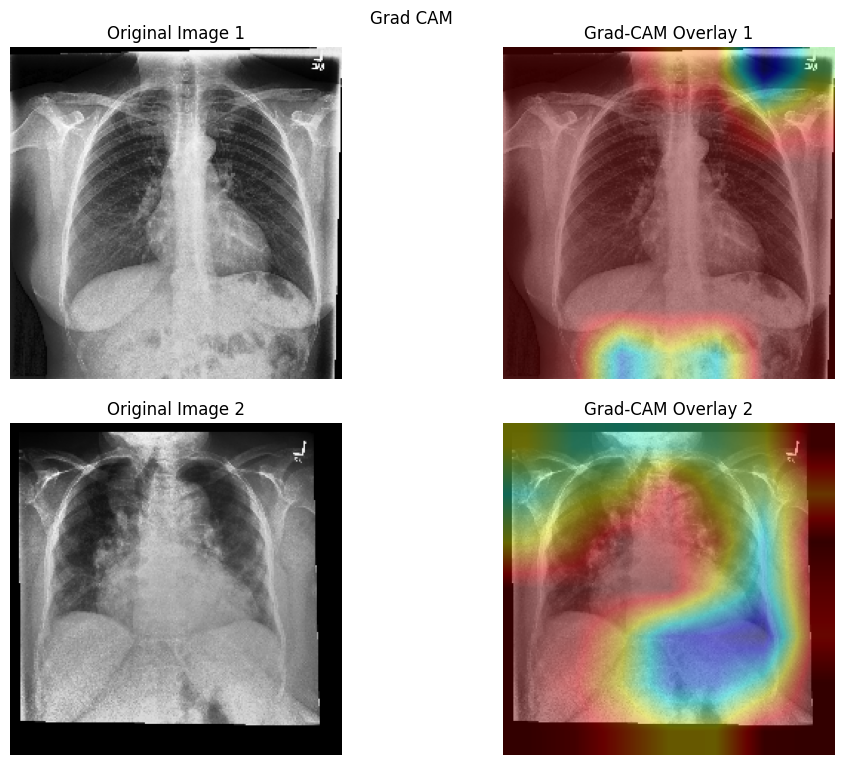

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
fig.suptitle('Grad CAM')
fig.tight_layout()

for i in range(2):  # i = 0, 1
    img_path = f"../test_xray{i+1}.jpg"
    img_array, orig_img = preprocess(img_path)

    last_conv_layer_name = "conv5_block16_concat"
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_name=last_conv_layer_name)
    heatmap = cv2.resize(heatmap, orig_img.size)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.array(orig_img), 0.6, heatmap_color, 0.4, 0)

    ax[i, 0].imshow(orig_img)
    ax[i, 0].set_title(f'Original Image {i+1}')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(superimposed_img)
    ax[i, 1].set_title(f'Grad-CAM Overlay {i+1}')
    ax[i, 1].axis('off')

plt.show()